In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.backend.clear_session()
tf.test.is_built_with_cuda()

True

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('Successful')
    except RuntimeError as e:
        print(e)

Successful


In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
esg = pd.read_csv('Data/esg.csv')
finaL_data = pd.read_csv('Data/final.csv')
financial_data = pd.read_csv('Data/financial_data.csv')
rain_temp = pd.read_csv('Data/rain_temp.csv')

In [6]:
finaL_data.drop(['Unnamed: 0'], axis=1, inplace=True)

Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = finaL_data.drop(['risk_factor'], axis=1)
y= finaL_data['risk_factor']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
y_train_binary = (y_train > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)

In [11]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import SimpleRNN, LSTM, Reshape, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential

SIMPLE RNN FOR STOCK PRICE PREDICTION

In [12]:
df = financial_data

In [13]:
data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train_data, test_data = data_normalized[0:train_size], data_normalized[train_size:len(data_normalized)]

sequence_length = 10

def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Reshape((-1, 50)))
model.add(Dropout(rate=0.3))

model.add(LSTM(50, activation='relu'))  
model.add(Reshape((-1, 50)))
model.add(Dropout(rate=0.3))

model.add(LSTM(50, activation='relu'))  
model.add(Reshape((-1, 50)))
model.add(Dropout(rate=0.3))

model.add(LSTM(50, activation='relu'))  
model.add(Reshape((-1, 50)))
model.add(Dropout(rate=0.3))

model.add(LSTM(50, activation='relu'))  
model.add(Reshape((-1, 50)))
model.add(Dropout(rate=0.3))

model.add(GRU(50, activation='relu'))  
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=["accuracy"])

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=2)

last_sequence = data_normalized[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, 1))
predicted_price = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(predicted_price)


Epoch 1/1000
3/3 - 10s - loss: 0.1930 - accuracy: 0.0114 - val_loss: 0.7371 - val_accuracy: 0.0000e+00 - 10s/epoch - 3s/step
Epoch 2/1000
3/3 - 0s - loss: 0.1920 - accuracy: 0.0114 - val_loss: 0.7349 - val_accuracy: 0.0000e+00 - 117ms/epoch - 39ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.1910 - accuracy: 0.0114 - val_loss: 0.7326 - val_accuracy: 0.0000e+00 - 108ms/epoch - 36ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.1900 - accuracy: 0.0114 - val_loss: 0.7304 - val_accuracy: 0.0000e+00 - 126ms/epoch - 42ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.1889 - accuracy: 0.0114 - val_loss: 0.7281 - val_accuracy: 0.0000e+00 - 142ms/epoch - 47ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.1879 - accuracy: 0.0114 - val_loss: 0.7259 - val_accuracy: 0.0000e+00 - 112ms/epoch - 37ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.1869 - accuracy: 0.0114 - val_loss: 0.7236 - val_accuracy: 0.0000e+00 - 140ms/epoch - 47ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.1858 - accuracy: 0.0114 - val_loss: 0.7213 - val_accuracy: 0.0000e+00 - 109

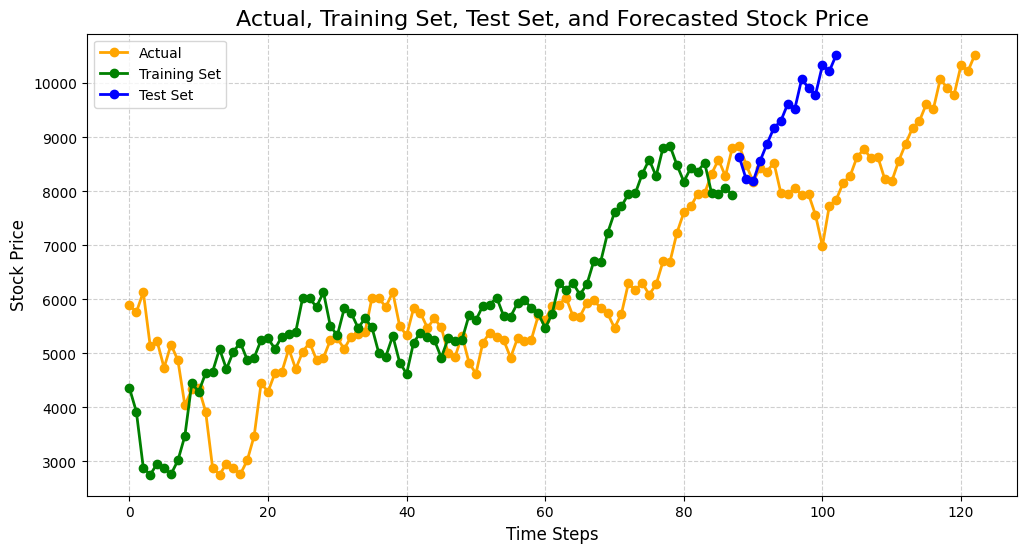

In [14]:
import matplotlib.pyplot as plt
import numpy as np

y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

x_original = np.arange(len(data))

x_train = np.arange(len(y_train_inverse))

x_test = np.arange(len(y_train_inverse), len(y_train_inverse) + len(y_test_inverse))

x_forecast = np.arange(len(data) - len(y_test_inverse), len(data))

plt.figure(figsize=(12, 6))
plt.title('Actual, Training Set, Test Set, and Forecasted Stock Price', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.plot(x_original, data, label='Actual', marker='o', color='orange', linewidth=2)
plt.plot(x_train, y_train_inverse, label='Training Set', marker='o', color='green', linewidth=2)
plt.plot(x_test, y_test_inverse, label='Test Set', marker='o', color='blue', linewidth=2)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Prediction of Risk

In [15]:
dsaa = finaL_data

In [16]:
dsaa

,0,1,2,3,4,5,6,7,8,9,...,14,15,risk_factor,Temperature,Rainfall,Open,High,Low,Close,Adj Close
0,0.0,0.163145,0.221199,0.269190,0.811113,0.034200,0.478400,0.129092,0.480325,0.886391,...,0.380972,0.834948,0.533296,0.545827,0.186578,0.296829,0.396464,0.350480,0.404541,0.404541
1,0.0,0.288917,0.094244,0.161097,0.621521,0.260872,0.533062,0.109217,0.286422,0.000000,...,0.199260,0.834942,0.187728,0.339607,0.043261,0.412386,0.401205,0.400650,0.386806,0.386806
2,0.0,0.109470,0.563978,0.064036,0.392630,0.381095,0.491720,0.360707,0.985021,0.413761,...,0.511882,0.162379,0.623078,0.114566,0.029400,0.394266,0.424080,0.436659,0.435143,0.435143
3,0.0,0.305092,0.212788,0.434344,0.708784,0.931107,0.115320,0.511304,0.346459,0.625532,...,0.341016,0.243501,0.538093,0.019640,0.030681,0.442896,0.446724,0.280026,0.306388,0.306388
4,0.0,0.890501,0.064565,0.483875,0.628338,0.365941,0.608854,0.722536,0.847694,0.432404,...,0.393623,0.649360,0.951165,0.129296,0.026205,0.312428,0.339650,0.325312,0.317455,0.317455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,0.942761,0.592022,0.489726,0.337584,0.205938,0.415135,0.314570,0.100538,0.498504,...,0.391796,0.541254,0.685041,0.807692,0.738817,0.962110,0.945329,0.947910,0.921189,0.921189
119,0.0,0.040605,0.392997,0.986877,0.781187,0.200841,0.634363,0.823253,0.482999,0.407519,...,0.344163,0.012276,0.642746,0.806874,0.501658,0.940709,0.950749,0.948165,0.904560,0.904560
120,0.0,0.091706,0.053171,0.822598,0.541041,0.229812,0.098365,0.128714,0.493352,0.328354,...,0.426905,0.522296,0.579994,0.735679,0.262235,0.934900,0.977857,0.966466,0.974870,0.974870
121,0.0,0.348479,0.202694,0.436980,0.040188,0.149317,0.114870,0.114818,0.671797,0.631307,...,0.332624,0.663377,0.370444,0.463993,0.038747,1.000000,0.991830,1.000000,0.960884,0.960884


Linear Regression

Mean Squared Error: 0.0056760220946343596
R-squared Score: 0.8561994738361616


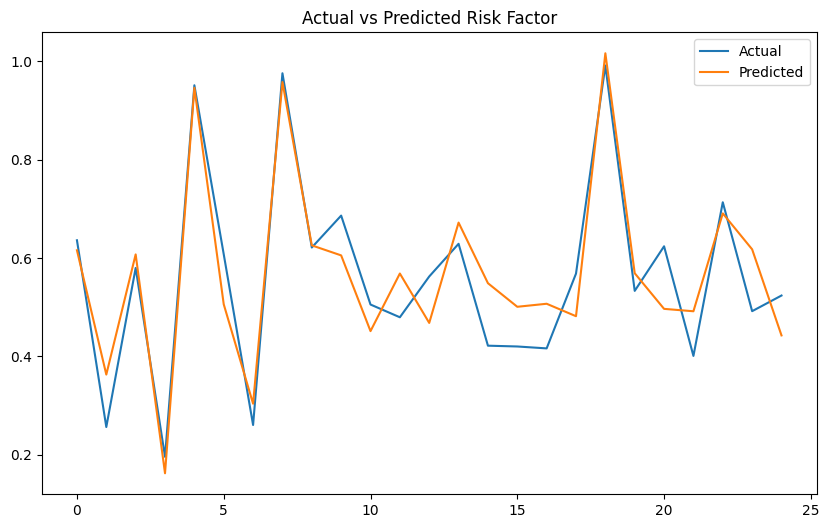

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = dsaa.drop(['risk_factor'], axis=1)
y = dsaa['risk_factor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Risk Factor')
plt.show()


Polynomial Regression

Mean Squared Error: 0.0015224087280259397
R-squared Score: 0.9614301754861909


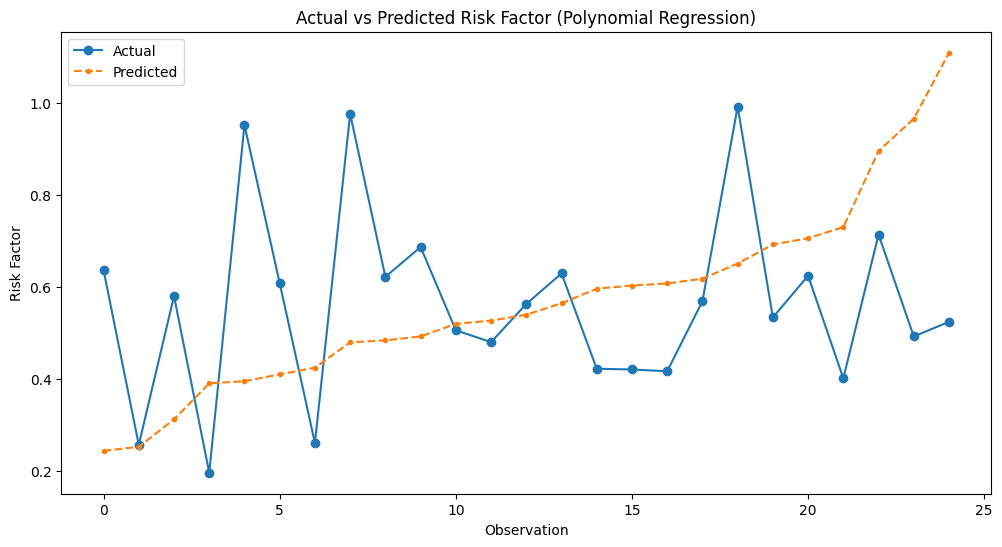

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = dsaa.drop(['risk_factor'], axis=1)
y = dsaa['risk_factor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


degree = 4
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_pred = poly_reg.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual', marker='o')

sorted_indices = X_test.index.argsort()
plt.plot(np.sort(y_pred), label='Predicted', linestyle='dashed', marker='.')

plt.legend()
plt.title('Actual vs Predicted Risk Factor (Polynomial Regression)')
plt.xlabel('Observation')
plt.ylabel('Risk Factor')
plt.show()

Random Forest Regressor

Mean Squared Error (Random Forest): 0.0034097499344210654
R-squared Score (Random Forest): 0.9136148826622126


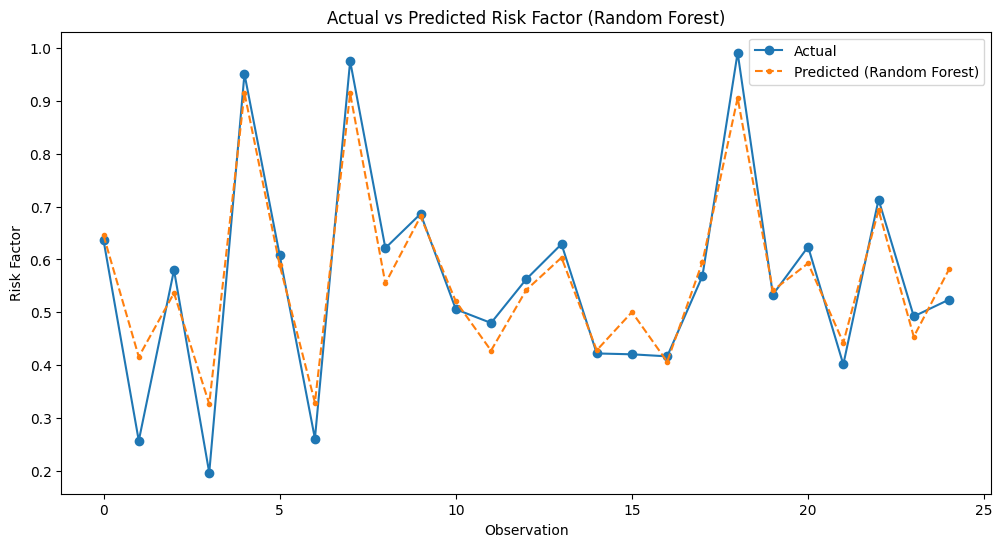

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
random_forest_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = random_forest_reg.predict(X_test)

# Evaluate the performance of the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared Score (Random Forest): {r2_rf}')

# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred_rf, label='Predicted (Random Forest)', linestyle='dashed', marker='.')
plt.legend()
plt.title('Actual vs Predicted Risk Factor (Random Forest)')
plt.xlabel('Observation')
plt.ylabel('Risk Factor')
plt.show()


Simple RNN

Epoch 1/1000
3/3 - 1s - loss: 0.3570 - accuracy: 0.0111 - 867ms/epoch - 289ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.2548 - accuracy: 0.0111 - 49ms/epoch - 16ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.1721 - accuracy: 0.0111 - 38ms/epoch - 13ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.1170 - accuracy: 0.0111 - 40ms/epoch - 13ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.0829 - accuracy: 0.0111 - 36ms/epoch - 12ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.0593 - accuracy: 0.0111 - 39ms/epoch - 13ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.0492 - accuracy: 0.0222 - 32ms/epoch - 11ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.0475 - accuracy: 0.0222 - 53ms/epoch - 18ms/step
Epoch 9/1000
3/3 - 0s - loss: 0.0512 - accuracy: 0.0111 - 53ms/epoch - 18ms/step
Epoch 10/1000
3/3 - 0s - loss: 0.0514 - accuracy: 0.0111 - 55ms/epoch - 18ms/step
Epoch 11/1000
3/3 - 0s - loss: 0.0485 - accuracy: 0.0111 - 47ms/epoch - 16ms/step
Epoch 12/1000
3/3 - 0s - loss: 0.0454 - accuracy: 0.0111 - 50ms/epoch - 17ms/step
Epoch 13/1000
3/3 - 0s 

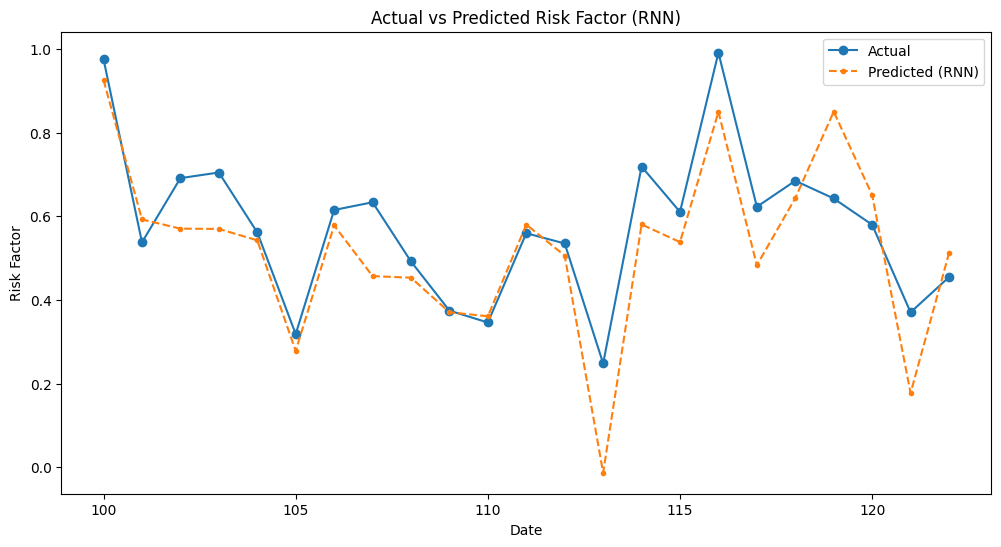

In [21]:

time_series = dsaa['risk_factor'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
time_series_normalized = scaler.fit_transform(time_series)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  

X, y = create_sequences(time_series_normalized, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["accuracy"])

model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=2)

y_pred_normalized = model.predict(X_test)


y_pred = scaler.inverse_transform(y_pred_normalized)
y_test_actual = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f'Mean Squared Error (RNN): {mse}')
print(f'R-squared Score (RNN): {r2}')

plt.figure(figsize=(12, 6))
plt.plot(dsaa.index[-len(y_test_actual):], y_test_actual, label='Actual', marker='o')
plt.plot(dsaa.index[-len(y_test_actual):], y_pred, label='Predicted (RNN)', linestyle='dashed', marker='.')
plt.legend()
plt.title('Actual vs Predicted Risk Factor (RNN)')
plt.xlabel('Date')
plt.ylabel('Risk Factor')
plt.show()
